# Importing libraries

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import numpy as np

from utils.utils import make_weekly_graph, make_daily_int_each_month
# from utils.readdbc import read_dbc
from utils.IBGETools import pop_ibge
from utils.HematoTools import make_all_dataset, download_layout, make_maps


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Preparing data <a name='prepare_data'></a>

## Loading DataFrame and maps

In [2]:
%%time
hemato = make_all_dataset(force_download=False)

CPU times: user 8 s, sys: 411 ms, total: 8.42 s
Wall time: 4.86 s


In [3]:
sex_map, cnes_map, uf_map, cid_map, et_map, financ_map, cbo_map, comp_map, mun_map = make_maps()

In [4]:
pop_df = pop_ibge()

In [5]:
hemato.head()

,N_AIH,UF_ZI,DT_INTER,DT_SAIDA,US_TOT,DIAS_PERM,ANO_CMPT,DIAG_PRINC,MORTE,IDADE,CNES,SEXO,ETNIA,COMPLEX,CAR_INT,MUNIC_RES,MUNIC_MOV,NASC
557,1208100036341,12,2008-01-25,2008-01-27,137.679993,2,2008,D594,0,34,5336171,3,,02,01,120020,120020,1973-10-08
623,1208100035714,12,2008-01-06,2008-01-09,154.679993,3,2008,D550,0,46,5336171,1,,02,01,120020,120020,1961-09-02
625,1208100035736,12,2008-01-20,2008-01-23,137.679993,3,2008,D550,0,17,5336171,1,,02,01,120020,120020,1990-09-07
652,1208100034010,12,2008-01-14,2008-01-16,129.649994,2,2008,D500,0,35,5336171,1,,02,01,120039,120020,1972-10-30
1962,1208100002241,12,2007-12-25,2008-01-07,220.169998,13,2008,D500,0,21,2002078,1,,02,01,120040,120040,1986-08-25


In [6]:
hemato.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954514 entries, 557 to 5029
Data columns (total 18 columns):
N_AIH         954514 non-null object
UF_ZI         954514 non-null object
DT_INTER      954514 non-null datetime64[ns]
DT_SAIDA      954514 non-null datetime64[ns]
US_TOT        954514 non-null float32
DIAS_PERM     954514 non-null uint16
ANO_CMPT      954514 non-null category
DIAG_PRINC    954514 non-null category
MORTE         954514 non-null uint8
IDADE         954514 non-null uint8
CNES          954514 non-null category
SEXO          954514 non-null category
ETNIA         954514 non-null category
COMPLEX       954514 non-null category
CAR_INT       954514 non-null category
MUNIC_RES     954514 non-null category
MUNIC_MOV     954514 non-null category
NASC          954514 non-null datetime64[ns]
dtypes: category(9), datetime64[ns](3), float32(1), object(2), uint16(1), uint8(2)
memory usage: 166.1 MB


# Exploratory Data Analisys

## Usando todos os dados:

### Internações por ano:

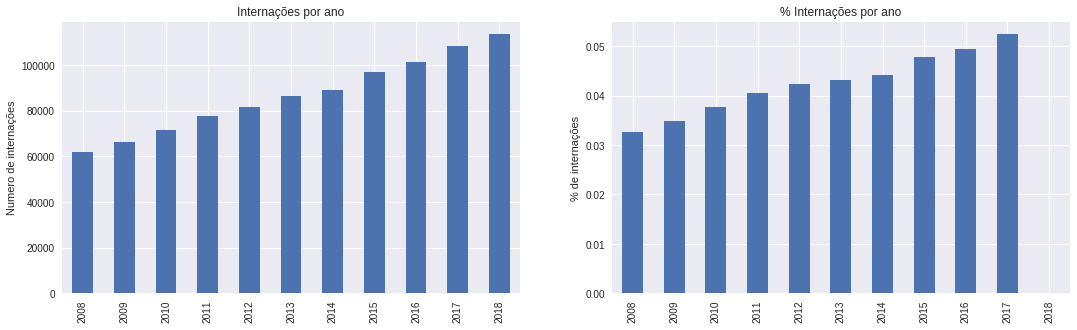

In [7]:
def plot_internações_por_ano():
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    fig.subplots_adjust(
        right=1,
        left=0
                       )
    hemato.ANO_CMPT.value_counts().sort_index().plot(kind='bar', title='Internações por ano',
                                                     ax=ax[0])
    ax[0].set_ylabel('Numero de internações')

    pop_total = pop_df.groupby('SIGLA').sum().sum()[:-1]
    int_ano = hemato.groupby('ANO_CMPT').N_AIH.count()
    (int_ano * 100 / pop_total).plot(kind='bar', title='% Internações por ano',
                                     ax=ax[1])
    ax[1].set_ylabel('% de internações')
    ax[1].set_xlabel('')

    plt.show()
    
plot_internações_por_ano()

### Internações por sexo:

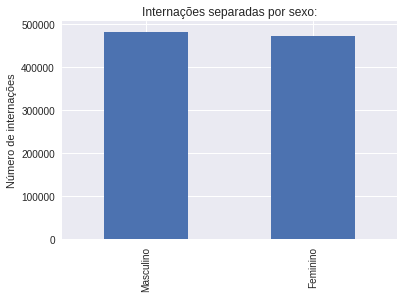

In [8]:
# TODO: comparar o percentual de internações em cada sexo, já que há mais mulheres do que homens

hemato.SEXO.map(sex_map).value_counts().plot(kind='bar')
plt.title('Internações separadas por sexo:')
plt.ylabel('Número de internações')
plt.show()

### Valor total recebido por AIH:

A escala é logarítmica por causa da amplitude dos valores.

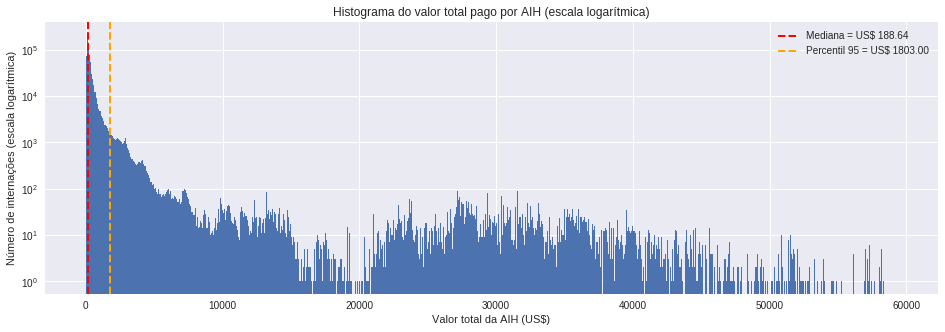

In [8]:
hemato.US_TOT.hist(log=True, bins=int(np.sqrt(len(hemato))), figsize=(16, 5))
median = hemato.US_TOT.quantile(.5)

q = .95
p = hemato.US_TOT.quantile(q)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = US$ {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2,
            label='Percentil {:.0f} = US$ {:.2f}'.format(q * 100, p))

plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH (escala logarítmica)')
plt.show()

#### Empirical cumulative distribution function:

Confirmando estatisticamente a distribuição exponencial dos valores.

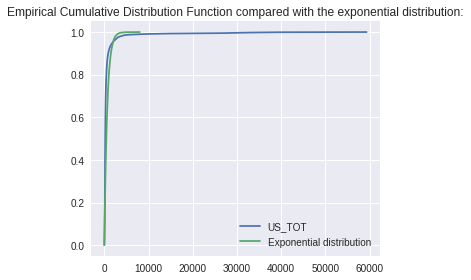

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(hemato.US_TOT)

mean = hemato.US_TOT.mean()

sample = np.random.exponential(mean, 100000)
cdf_sample = ECDF(sample)


plt.plot(ecdf.x, ecdf.y, label='US_TOT')
plt.plot(cdf_sample.x, cdf_sample.y, label='Exponential distribution')
plt.legend()
plt.title('Empirical Cumulative Distribution Function compared with the exponential distribution:')
plt.tight_layout()
plt.show()

# a US_TOT tem distribuição exponencial

#### Retirei a escala log para comparar.

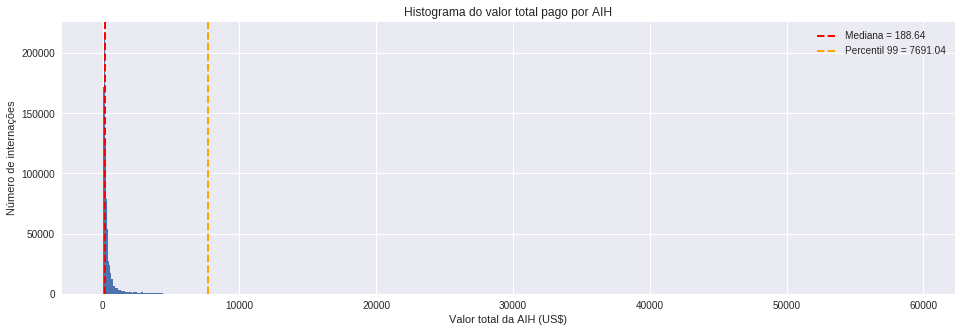

In [10]:
hemato.US_TOT.hist(log=False, bins=int(np.sqrt(len(hemato))), figsize=(16, 5))
median = hemato.US_TOT.quantile(.5)

mean = hemato.US_TOT.mean()

p = hemato.US_TOT.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {:.2f}'.format(p))

plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('Número de internações')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH')
plt.show()

### Evolução do total de internações absolutas no período:

* Claramente aumentou o número absoluto
* Parece que as vezes a velocidade de crescimento diminui um pouco no inverno com picos em fevereiro

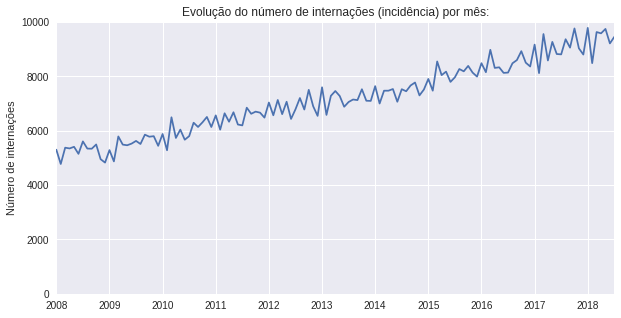

In [9]:
# TODO: ver a população a cada ano e ver se aumentou o percentual de internações hemato

int_by_day = pd.to_datetime(hemato.DT_INTER).value_counts()

int_by_day['2008':'2018'].resample('M').sum()[:-5].plot(figsize=(10, 5),
                                                        ylim=(0, 10000))
plt.title('Evolução do número de internações (incidência) por mês:')
plt.ylabel('Número de internações')
plt.show()

### Evolução da média de internações no ano anterior:

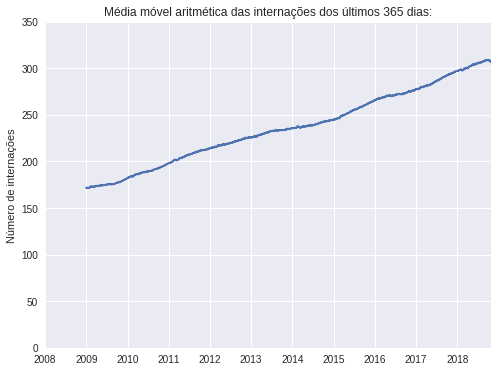

(cada ponto é a média das internações dos últimos 365 dias)


In [12]:
int_by_day['2008':'2018'].resample('D').sum().rolling(365).mean()[:-60].plot(figsize=(8, 6),
                                                                             ylim=(0, 350))
plt.title('Média móvel aritmética das internações dos últimos 365 dias:')
plt.ylabel('Número de internações')
plt.show()
print('(cada ponto é a média das internações dos últimos 365 dias)')

### Internações totais por dia do mês:

* Os dias com menos internações são feriados.
* Esta informação é útil para planejar cobertura de sobreavisos e plantões

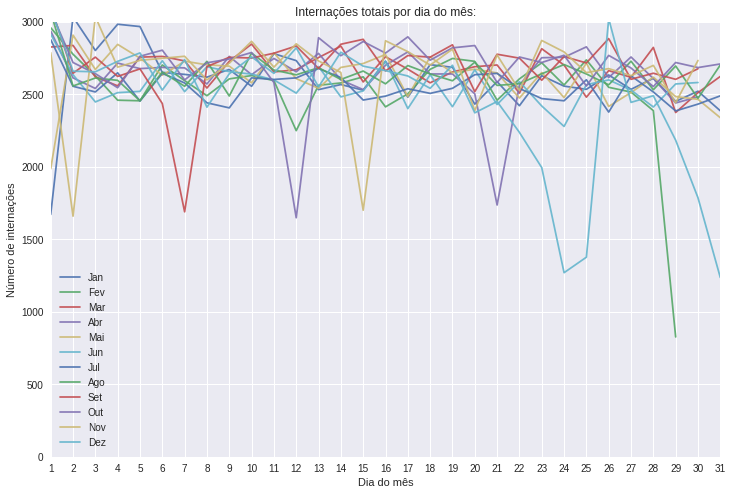

In [13]:
make_daily_int_each_month(hemato)

### Média de internações por dia da semana em todo o período:

* Analisando o intervalo de confiança, as internações no início da semana parecem variar muito, mas, na sexta e sábado, a média de internações diminui com um intervalo de confiança mais estreito.
    * Provavelmente porque aumentou o número absoluto

In [15]:
# TODO: Separar por períodos, talvez bianual, esta média

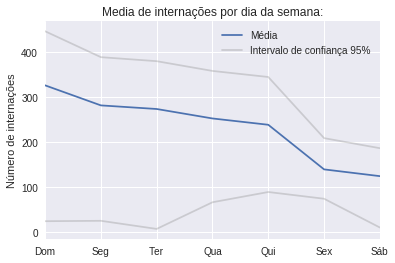

CPU times: user 22.2 s, sys: 5.73 ms, total: 22.2 s
Wall time: 22.3 s


In [14]:
%%time

# TODO: numba ou dask to increase performance
# TODO: fazer prevalência

int_by_day.groupby(int_by_day.index.weekday).median().plot(label='Média')

for i in range(5000):
    bootstrap = {}
    for day in range(7):
        bootstrap[day] = (int_by_day[int_by_day.index.weekday == day].sample(frac=1, replace=True)).values

rep_25 = []
rep_975 = []
for k, v in bootstrap.items():
    rep_25.append(np.percentile(v, 2.5))
    rep_975.append(np.percentile(v, 97.5))

plt.plot(rep_25, alpha=.3, c='gray', label='Intervalo de confiança 95%')
plt.plot(rep_975, alpha=.3, c='gray')

plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.title('Media de internações por dia da semana:')
plt.ylabel('Número de internações')
plt.legend()
plt.ylim=(0,500)
plt.show()

### Total de internações por dia da semana:
* parece que não muda o padrão nos meses do ano

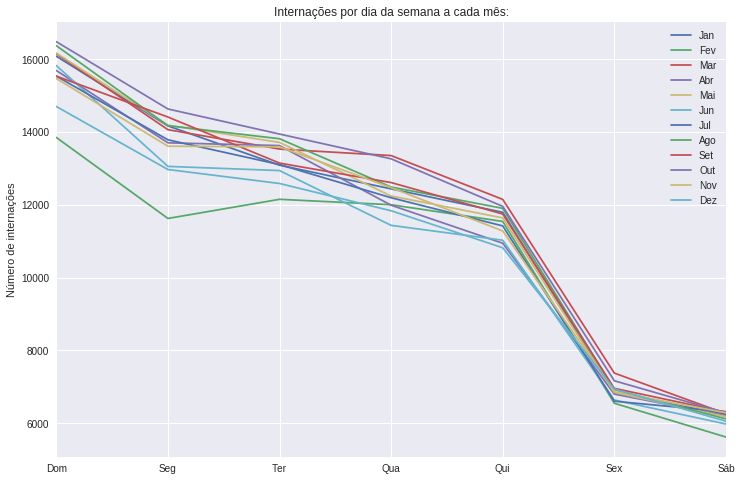

Parece que não muda muito o padrão.


In [17]:
make_weekly_graph(hemato)

### Altas por dia da semana, em cada mês:
* (planejamento de plantões/sobreavisos)
* não é a prevalência, é o número de novas internações (incidência)

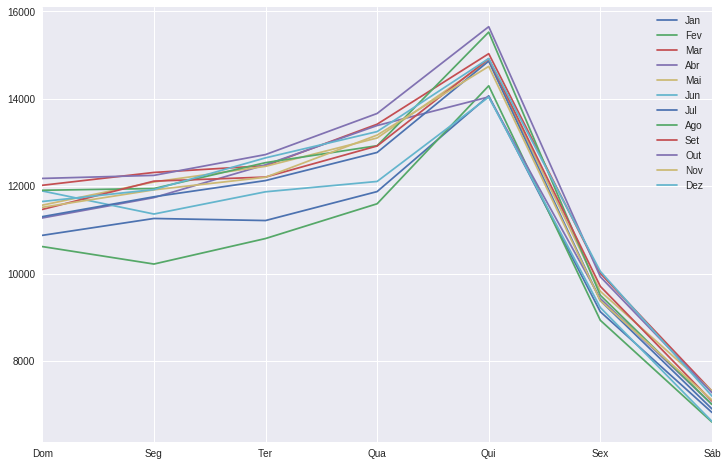

In [16]:
# TODO: fazer a média e o IC, como nas internações
# TODO: fazer prevalência

months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

pivoted = hemato.pivot_table('N_AIH', index=hemato.DT_SAIDA.dt.weekday, 
                             columns=hemato.DT_SAIDA.dt.month,
                             aggfunc='count')

pivoted.columns.name = None
pivoted.columns = months
pivoted.index.name = None

pivoted.plot(figsize=(12, 8), legend=True)
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.show()

### Tempo de internação em todo o período
* Escala logarítmica

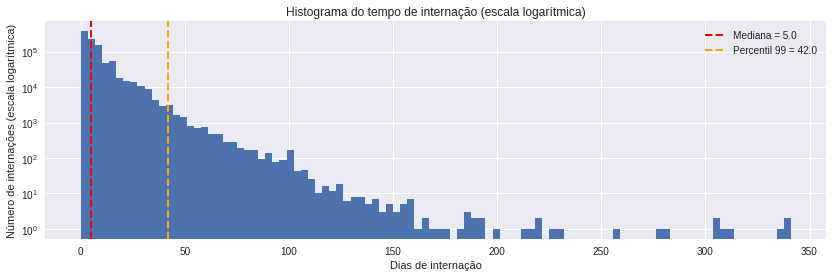

In [17]:
# TODO: fazer um ECDF para confirmar a distribuição exponencial

hemato.DIAS_PERM.hist(bins=100, log=True, figsize=(14, 4))
median = hemato.DIAS_PERM.quantile(.5)
p = hemato.DIAS_PERM.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {}'.format(p))

plt.xlabel('Dias de internação')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do tempo de internação (escala logarítmica)')
plt.show()

### % de óbitos por doença:

In [21]:
mortes = hemato[hemato.MORTE == 1].DIAG_PRINC.map(cid_map).value_counts(ascending=False)
tot = hemato.DIAG_PRINC.map(cid_map).value_counts(ascending=False)
round((mortes / tot).sort_values(ascending=False) * 100, 2)[:20]

Embolia pulmonar com menção de cor pulmonale agudo           21.67
Leucemia aguda de tipo celular não especificado              15.54
Doença de Sézary                                             15.29
Leucemia plasmocitária                                       14.68
Leucemia linfocítica crônica                                 14.57
Anemia refratária com excesso de blastos                     14.14
Linfoma de células T, periférico                             13.16
Doença mieloproliferativa crônica                            12.51
Leucemia mielomonocítica aguda                               12.39
Outros linfomas de células T e os não especificados          12.37
Leucemia mielóide crônica                                    12.30
Síndrome hematofagocítica associada à infecção               12.03
Plasmocitoma extramedular                                    11.19
Leucemia mielóide aguda                                      11.17
Linfoma não-Hodgkin, grandes células, folicular              1

## Segmentando por UF:

### Internações totais e percentuais por UFs 

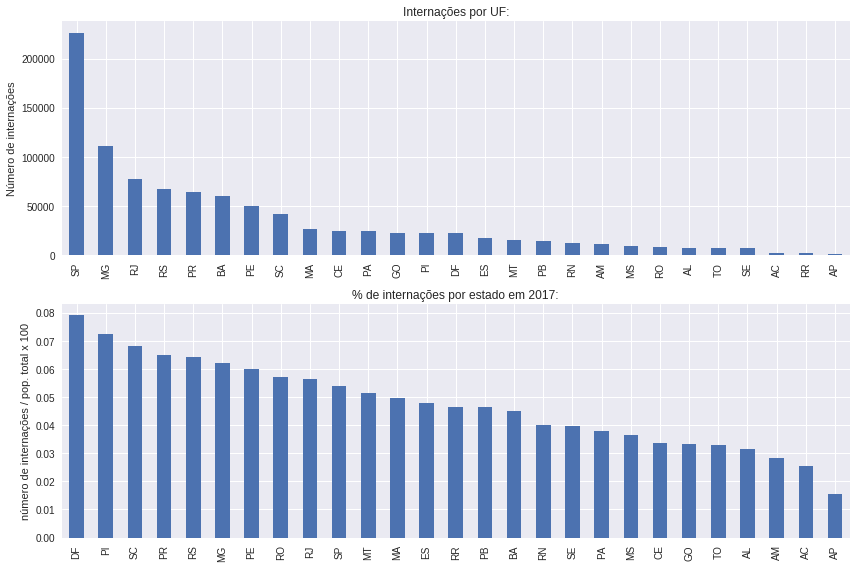

In [24]:
hemato['UF'] = hemato.UF_ZI.map(uf_map)

def plot_internacoes_por_estado():
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    hemato.UF.value_counts().plot(kind='bar', title='Internações por UF:', ax=ax[0])
    ax[0].set_ylabel('Número de internações')

    int_uf_2017 = hemato.groupby(['ANO_CMPT', 'UF']).N_AIH.count()['2017']
    pop_total = pop_df.groupby('SIGLA').sum()
    (int_uf_2017 * 100 / pop_total['2017']).sort_values(ascending=False).plot(kind='bar',
                                                  title='% de internações por estado em 2017:',
                                                  ax=ax[1])
    ax[1].set_ylabel('número de internações / pop. total x 100')
    ax[1].set_xlabel('')

    plt.tight_layout()
    plt.show()
    
plot_internacoes_por_estado()

#### Internações totais no RS por hospital, maiores de 18 anos:

In [25]:
# TODO: fazer outros UFs

def group_int_por_hosp(uf, _map=True, age=18):
    uf = hemato[(hemato.UF == uf) & (hemato.IDADE >= age)]
    if _map:
        mapped = uf.loc[:, 'CNES'].map(cnes_map, na_action='ignore').copy()
        uf.loc[:, 'CNES'] = mapped.copy()
        mapped = uf.loc[:, 'MUNIC_MOV'].map(mun_map,na_action='ignore').copy()
        uf.loc[:, 'MUNIC_MOV'] = mapped.copy()
    group = uf.groupby(['MUNIC_MOV', 'CNES']).SEXO.count().sort_values(ascending=False)
    return group

group = group_int_por_hosp('RS', _map=1, age=18)
group.loc[group > 1000]

MUNIC_MOV       CNES                                                   
Porto Alegre    HOSPITAL DE CLINICAS                                       4998
                HOSPITAL NOSSA SENHORA DA CONCEICAO SA                     3605
Santa Maria     HUSM HOSPITAL UNIVERSITARIO DE SANTA MARIA                 2418
Passo Fundo     HOSPITAL SAO VICENTE DE PAULO                              1856
São Borja       HOSPITAL INFANTIL                                          1458
Porto Alegre    IRMANDADE DA SANTA CASA DE MISERICORDIA DE PORTO ALEGRE    1303
Caxias do Sul   HOSPITAL GERAL                                             1080
Venâncio Aires  HOSPITAL SAO SEBASTIAO MARTIR                              1077
Lajeado         HOSPITAL BRUNO BORN                                        1054
Name: SEXO, dtype: int64

## GHC x HCPA

### Compara HCPA e GHC número de internações por doenças em maiores de 18 anos:

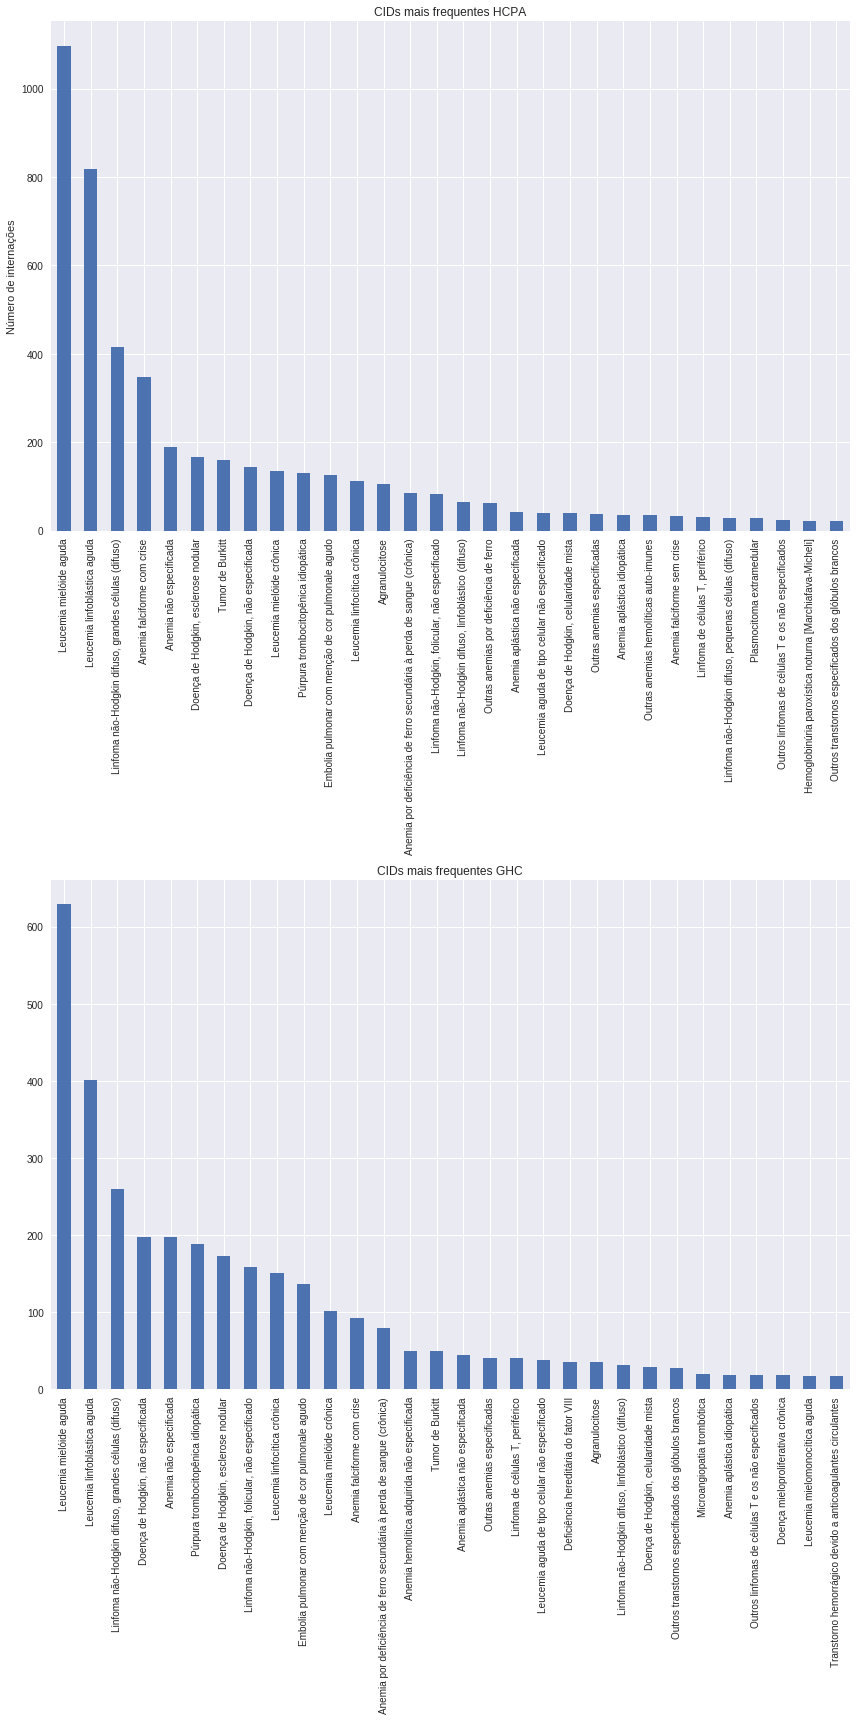

In [26]:
def int_cid_x_cnes(cnes, head=30, age=18):
    return hemato[(hemato.CNES == cnes) & (hemato.IDADE >= age)].DIAG_PRINC.map(cid_map).value_counts().head(head)
    
hcpa = int_cid_x_cnes('2237601')
ghc = int_cid_x_cnes('2237571')

fig, ax = plt.subplots(2, 1, figsize=(12, 24))#, sharey=True)

hcpa.plot(kind='bar', ax=ax[0], title='CIDs mais frequentes HCPA')
ax[0].set_ylabel('Número de internações')
ghc.plot(kind='bar', ax=ax[1], title='CIDs mais frequentes GHC')
plt.tight_layout()
plt.savefig('images/int_cid_hcpa_x_ghc.png')
plt.show()

### Compara GHC e HCPA em internações de menores de 18 anos:

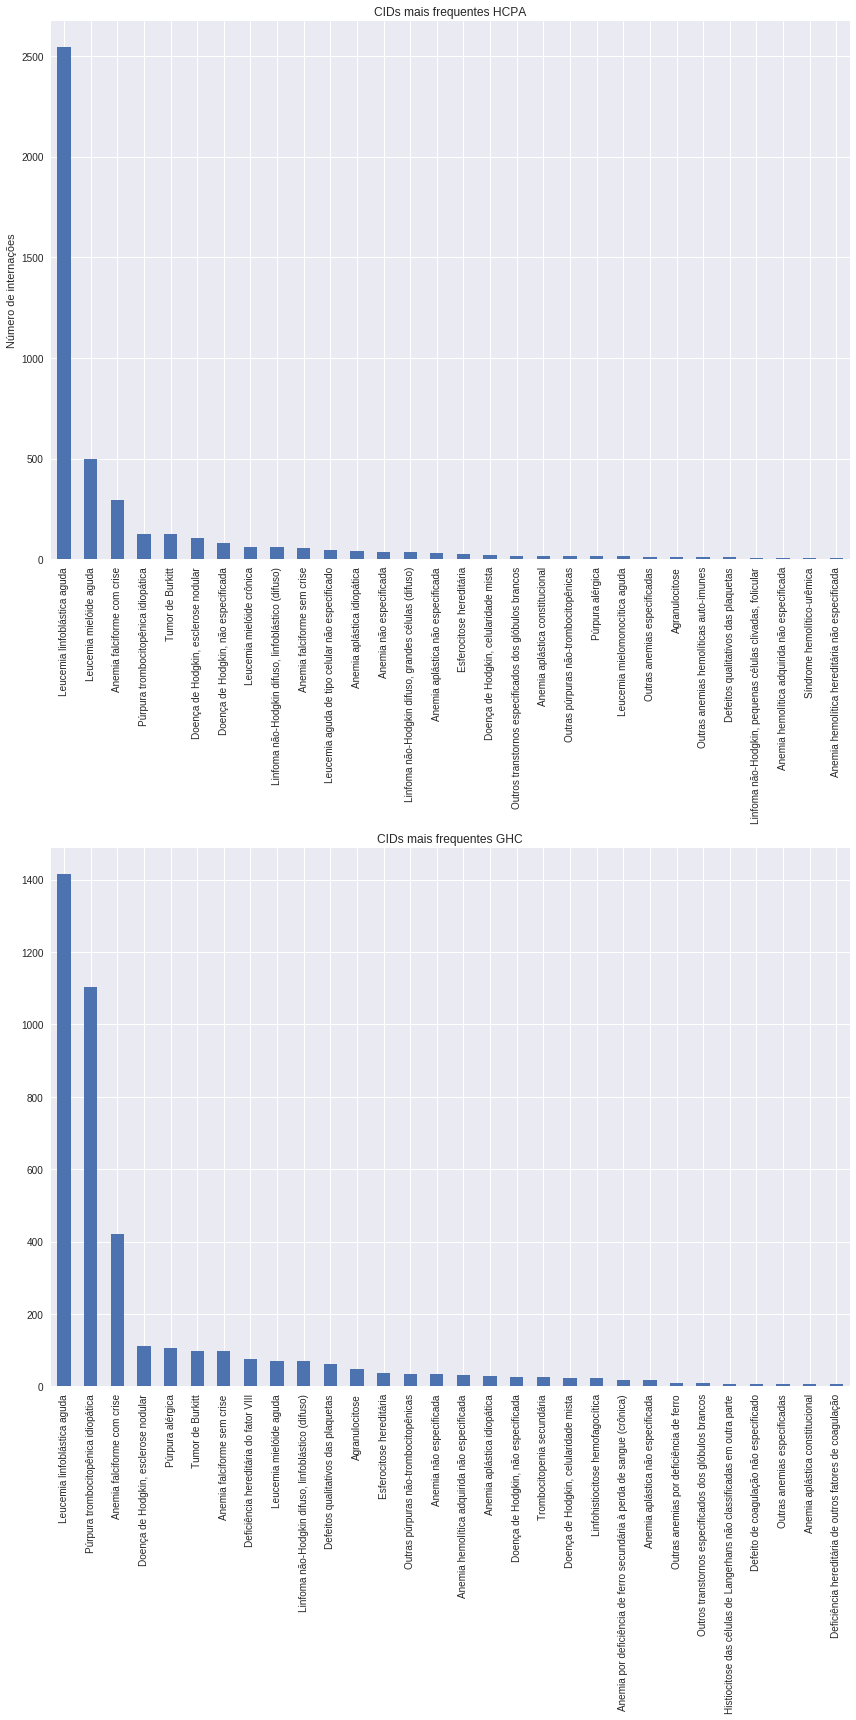

In [30]:
def int_cid_x_cnes(cnes, head=30, age=18):
    return hemato[(hemato.CNES == cnes) & (hemato.IDADE < age)].\
                    DIAG_PRINC.map(cid_map).value_counts().head(head)
    
hcpa = int_cid_x_cnes('2237601')
ghc = int_cid_x_cnes('2237571')

fig, ax = plt.subplots(2, 1, figsize=(12, 24))#, sharey=True)
plt.title('Internações menores de 18 anos')
hcpa.plot(kind='bar', ax=ax[0], title='CIDs mais frequentes HCPA')
ax[0].set_ylabel('Número de internações')
ghc.plot(kind='bar', ax=ax[1], title='CIDs mais frequentes GHC')
plt.tight_layout()
plt.savefig('images/int_cid_hcpa_x_ghc_menores.png')
plt.show()

## Segmentando por idade

### Internações totais no RS, < de 18 anos:

In [31]:
uf = hemato[(hemato.IDADE < 18) & (hemato.UF == 'RS')]
mapped = uf.loc[:, 'CNES'].map(cnes_map, na_action='ignore').copy()
uf.loc[:, 'CNES'] = mapped.copy()
mapped = uf.loc[:, 'MUNIC_MOV'].map(mun_map,na_action='ignore').copy()
uf.loc[:, 'MUNIC_MOV'] = mapped.copy()
uf.groupby(['MUNIC_MOV', 'CNES']).SEXO.count().sort_values(ascending=False)

MUNIC_MOV               CNES                                                   
Porto Alegre            HOSPITAL DE CLINICAS                                       4472
                        HOSPITAL NOSSA SENHORA DA CONCEICAO SA                     4113
Santa Maria             HUSM HOSPITAL UNIVERSITARIO DE SANTA MARIA                 2500
Porto Alegre            IRMANDADE DA SANTA CASA DE MISERICORDIA DE PORTO ALEGRE    1983
Passo Fundo             HOSPITAL SAO VICENTE DE PAULO                              1170
Caxias do Sul           HOSPITAL GERAL                                              561
Porto Alegre            HOSPITAL SAO LUCAS DA PUCRS                                 518
Pelotas                 HOSPITAL ESCOLA DA UNIVERSIDADE FEDERAL DE PELOTAS          206
São Borja               HOSPITAL INFANTIL                                           189
Passo Fundo             HOSPITAL DE CLINICAS                                        180
Rio Grande              FAHERG          

## Machine Learning

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

from tempfile import mkdtemp
from shutil import rmtree

### Clustering

#### Finding the optimal value of n_clusters using just a sample

In [27]:
X = hemato.drop(['N_AIH', 'DT_INTER', 'DT_SAIDA', 'NASC'], axis=1).sample(50000)

In [26]:
dum = pd.get_dummies(X, sparse=True)

In [28]:
dum.shape

(50000, 65496)

In [34]:
X.shape
ohe = OneHotEncoder()
enc = ohe.fit_transform(X)

ValueError: Input contains NaN

In [28]:

def make_cluster_graph(n):
    steps = [
        ('ohe', OneHotEncoder()),
        ('scale', MaxAbsScaler()),
    ]

    pipe = Pipeline(steps)
    X_pipe = pipe.fit_transform(X)

    mini = MiniBatchKMeans(n)
    mini.fit(X_pipe)

    labels = mini.predict(X_pipe)
    return mini.inertia_

In [29]:
inertias = []
_range = range(2, 101)

for n in _range:
    z = make_cluster_graph(n)
    inertias.append(z)

ValueError: Input contains NaN

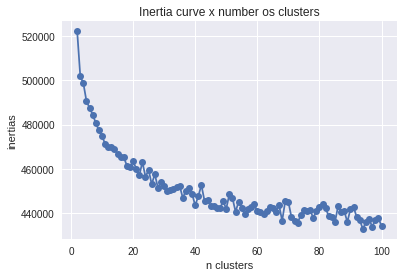

In [38]:
plt.plot(_range, inertias, '-o')
plt.ylabel('inertias')
plt.xlabel('n clusters')
plt.title('Inertia curve x number os clusters')
plt.show()

# The optimal number of clusters is about 45

#### MiniBatchKMeans with 45 clusters using all dataset

In [41]:
X = hemato.drop(['DT_INTER', 'DT_SAIDA'], axis=1)

n = 45 # optimal value
steps = [
    ('ohe', OneHotEncoder()),
    ('scale', MaxAbsScaler()),
    ('mini', MiniBatchKMeans(n))
]

pipe = Pipeline(steps)
labels = pipe.fit_predict(X)

In [58]:
from sklearn.random_projection import SparseRandomProjection

steps = [
    ('ohe', OneHotEncoder()),
    ('scale', MaxAbsScaler()),
    ('dim_red', SparseRandomProjection()),
    ('mini', MiniBatchKMeans(n))
]

pipe = Pipeline(steps) #, memory=cachedir)
labels_2 = pipe.fit_predict(X)

In [68]:
l1 = []
l2 = []
for l in range(45):
    l1.append(len(hemato[labels == l]))
    l2.append(len(hemato[labels_2 == l]))
    
df_len = pd.DataFrame({'Labels': l1, 'Labels_2': l2})

In [69]:
df_len

,Labels,Labels_2
0,29314,29
1,35779,37956
2,107541,31118
3,45235,11264
4,51941,22513
5,62225,58787
6,21128,41256
7,18658,1723
8,43656,28231
9,16642,49594


In [79]:
l1 = []
l2 = []
for l in range(45):
    l1.append(hemato[labels == l].DIAG_PRINC.value_counts())
    l2.append(hemato[labels_2 == l].DIAG_PRINC.value_counts())
    
df_diag_1 = pd.concat(l1, axis=1)
df_diag_1.columns = range(45)

df_diag_2 = pd.concat(l2, axis=1)
df_diag_2.columns = range(45)

In [80]:
df_diag_1.T.describe()

,C811,C812,C813,C819,C820,C821,C822,C829,C830,C833,C835,C837,C840,C841,C844,C845,C880,C901,C902,C910,C911,C915,C920,C921,C925,C942,C950,D339,D45,D460,D461,D462,D463,D464,D471,D472,D473,D500,D508,D510,D518,D520,D521,D550,D551,D561,D563,D568,D569,D570,...,D595,D599,D600,D601,D610,D611,D613,D619,D641,D642,D648,D649,D65,D66,D67,D680,D681,D682,D683,D684,D688,D689,D690,D691,D692,D693,D695,D698,D70,D721,D728,D730,D731,D732,D750,D751,D752,D760,D761,D762,D890,D891,E831,I260,I780,M250,M311,M329,M362,R71
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,181.244444,40.555556,17.022222,394.866667,52.933333,16.088889,31.711111,183.022222,155.422222,421.022222,89.555556,193.488889,16.355556,3.000000,31.955556,69.044444,9.111111,17.111111,16.888889,3238.422222,187.644444,13.022222,1465.511111,227.955556,26.200000,5.777778,98.800000,14.133333,10.866667,9.733333,2.577778,13.488889,20.022222,61.355556,33.844444,12.933333,11.355556,663.888889,359.488889,19.511111,29.311111,8.888889,3.466667,92.600000,12.155556,9.777778,0.511111,4.355556,12.733333,1440.355556,...,7.311111,577.155556,112.666667,5.533333,72.200000,14.444444,78.688889,648.533333,5.444444,4.955556,619.800000,3075.200000,62.466667,149.244444,30.777778,13.222222,1.800000,8.488889,54.044444,7.244444,72.733333,138.333333,76.244444,66.866667,68.022222,493.266667,22.088889,72.266667,297.777778,7.777778,77.755556,2.755556,51.80000,35.044444,4.133333,19.822222,13.133333,10.800000,5.533333,5.711111,0.177778,0.288889,12.822222,479.111111,0.822222,4.111111,62.044444,143.022222,1.800000,0.444444
std,272.679645,60.305116,28.750090,544.283750,77.329696,25.875420,44.420830,259.701970,218.371503,570.581222,137.940790,296.492267,25.436334,5.616534,56.762646,132.091214,14.233798,27.322337,25.746334,5000.526397,325.373642,24.775803,2098.126909,312.762323,49.979359,8.519733,171.666643,21.688497,20.216555,18.812955,5.594189,31.603813,45.750057,124.549215,65.906599,37.156548,16.412517,1297.687808,757.445756,40.420867,55.122517,18.717059,6.874194,170.572219,23.906024,18.527484,1.120516,8.975106,24.679215,2774.992073,...,13.810112,1335.763468,242.758297,12.333620,119.218211,31.606642,114.685107,1353.835236,16.508339,12.567917,1184.181509,9954.082768,136.692355,364.906536,82.822068,22.076200,4.197402,14.539323,101.155810,13.648436,133.347018,272.349041,152.931232,137.220228,136.860328,943.407855,39.813670,133.387406,554.172761,13.326134,135.668740,5.152914,115.10047,77.611490,7.895914,50.689020,24.381998,19.017456,11.050710,10.807452,0.441531,0.869227,29.121445,997.004519,1.599558,10.057160,113.407142,283.096553,4.490394,1.216469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [81]:
df_diag_2.T.describe()

,C811,C812,C813,C819,C820,C821,C822,C829,C830,C833,C835,C837,C840,C841,C844,C845,C880,C901,C902,C910,C911,C915,C920,C921,C925,C942,C950,D339,D45,D460,D461,D462,D463,D464,D471,D472,D473,D500,D508,D510,D518,D520,D521,D550,D551,D561,D563,D568,D569,D570,...,D595,D599,D600,D601,D610,D611,D613,D619,D641,D642,D648,D649,D65,D66,D67,D680,D681,D682,D683,D684,D688,D689,D690,D691,D692,D693,D695,D698,D70,D721,D728,D730,D731,D732,D750,D751,D752,D760,D761,D762,D890,D891,E831,I260,I780,M250,M311,M329,M362,R71
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,181.244444,40.555556,17.022222,394.866667,52.933333,16.088889,31.711111,183.022222,155.422222,421.022222,89.555556,193.488889,16.355556,3.000000,31.955556,69.044444,9.111111,17.111111,16.888889,3238.422222,187.644444,13.022222,1465.511111,227.955556,26.200000,5.777778,98.800000,14.133333,10.866667,9.733333,2.577778,13.488889,20.022222,61.355556,33.844444,12.933333,11.355556,663.888889,359.488889,19.511111,29.311111,8.888889,3.466667,92.600000,12.155556,9.777778,0.511111,4.355556,12.733333,1440.355556,...,7.311111,577.155556,112.666667,5.533333,72.200000,14.444444,78.688889,648.533333,5.444444,4.955556,619.800000,3075.200000,62.466667,149.244444,30.777778,13.222222,1.800000,8.488889,54.044444,7.244444,72.733333,138.333333,76.244444,66.866667,68.022222,493.266667,22.088889,72.266667,297.777778,7.777778,77.755556,2.755556,51.800000,35.044444,4.133333,19.822222,13.133333,10.800000,5.533333,5.711111,0.177778,0.288889,12.822222,479.111111,0.822222,4.111111,62.044444,143.022222,1.800000,0.444444
std,207.638032,49.738204,23.492251,380.582663,53.707711,17.884506,31.865215,183.402128,169.150752,427.341065,96.581702,201.949884,21.975354,5.183014,36.844239,86.836303,11.283983,18.559759,18.487369,4211.942736,197.206301,19.000585,1403.539481,212.231965,37.361623,7.994000,102.521306,16.002273,14.509558,14.840669,4.702460,28.413843,36.800129,81.907974,41.556618,26.171984,13.026469,1112.504570,1101.625341,34.841604,54.022227,15.758435,6.344647,142.735037,21.906781,17.347896,1.198905,6.023271,19.758082,2190.942420,...,10.328298,1265.625662,168.972833,9.408893,95.533335,20.905149,80.574026,1000.751027,8.630168,8.442198,872.762896,7823.541547,137.905040,250.642099,50.905835,17.884591,3.093982,12.101131,78.849960,10.898614,105.798995,206.448871,123.558811,108.733745,111.421699,776.101575,28.042842,125.630483,446.831313,10.144163,97.636421,4.200409,67.595925,46.178486,6.214353,29.406469,19.934666,15.142655,8.256127,8.812755,0.490310,0.815259,22.391444,659.132047,1.192570,7.468790,92.036790,291.696253,3.401871,0.692675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [70]:
hemato.columns

Index(['N_AIH', 'DT_INTER', 'DT_SAIDA', 'US_TOT', 'DIAS_PERM', 'ANO_CMPT',
       'DIAG_PRINC', 'MORTE', 'IDADE', 'CNES', 'UF', 'SEXO', 'ETNIA',
       'COMPLEX', 'CAR_INT', 'MUNIC_RES', 'MUNIC_MOV'],
      dtype='object')

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X, y)
dummy = clf.predict(X)

print('Dummy accuracy: {}'.format(accuracy_score(y, dummy)))

In [ ]:
# Searching for correlations using pandas.corr
# TODO: Is this corr the same each year?

data = pd.DataFrame(X_scaled, columns=hemato.columns).drop(['N_AIH', 'DT_INTER', 'DT_SAIDA'], axis=1)
corr = data.corr('spearman')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, '{} %'.format(int(corr.iloc[i, j] ** 2 * 100)),
                       ha="center", va="center", color="k")
plt.show()

# o percentual se refere ao quanto a variação do eixo y é atribuida ao x

In [ ]:
from scipy.stats import pearsonr, spearmanr
p = pearsonr(X_scaled[0], X_scaled[1])
s = spearmanr(X_scaled[0], X_scaled[1])

## Todo:

X DIAG_PRINC separar CIDs de hemato antes de juntar os arquivos.

X Por que o N_AIH tem numeros repetidos? Interna várias vezes com o mesmo registro? Erro?

Identificar a cidade pelo CEP e verificar quem tem um endereço e interna em outra cidade/estado.

Posso usar o MUNIC_RES pra fazer o que escrevi acima.

UTI_MES_TO e UTI_INT_TO pode dizer quais CIDs são mais graves. Se o percentual de internações graves aumentou. Posso relacionar se morrem muito na UTI ou se salvam muito.

Hemato ganha muita diaria de acompanhante? DIAR_ACOM

Quais CIDs ficam mais tempo internado? QT_DIARIAS Algum estado demora mais no tratamento, comparando mesmas doenças? Isso se reflete no resultado do tto?

----------
##### Financeiro

VAL_SH (hosp) VAL_SP (profissional) VAL_TOT VAL_UTI US_TOT Quanto paga cada internação de hemato? Qual paga mais?

FINANC A grana vem de onde?

VAL_SADT, VAL_ACOMP, VAL_SANGUE está zerado???

90 VAL_SH_FED numeric (10, 2) Valor do complemento federal de serviços hospitalares. Está
 incluído no valor total da AIH.

91 VAL_SP_FED numeric (10, 2) Valor do complemento federal de serviços profissionais. Está
 incluído no valor total da AIH.

92 VAL_SH_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços hospitalares. Está incluído no valor total da AIH.

93 VAL_SP_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços profissionais. Está incluído no valor total da AIH.
 
VAL_UCI O que é UCI???

-----------

DT_INTER DT_SAIDA DIAS_PERM Datas de int e alta conferem com as diárias? Há datas de anos/meses anteriores que contaram nesta competencia (atraso de envio?)

Não incluí a natureza jurídica e a gestão porque é certo que vai ter mais internações nos tipos de lugares que existem, seja por imposição legal ou incentivo fiscal. Não quer dizer que sejam mais importantes.

MUNIC_MOV Municipio do estabelecimento. Este dado é confiável? Se for, posso usar pra comparar com o MUNIC_RES.

COD_IDADE IDADE Perfil de idade dos pacientes atendidos.

NACIONAL Nacionalidade do paciente

CAR_INT Vem muito pct hemato de emergência?

CBOR NUM_FILHOS INSTRU VINCPREV Acho importante pra comparar por regiões e por tempo, mas tenho dúvidas da veracidade dos dados.

RACA_COR ETNIA Comparar as duas classificações.

Qual a prevalência de pacientes internados? (Como calcular a prevalencia?)